# NHLPanthers - Full season
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 93 # NHLPanthers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrNHLPanthers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(16262, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16262 entries, 0 to 16261
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            16262 non-null  int64  
 1   dimCustomerMasterId     16262 non-null  int64  
 2   customerNumber          16262 non-null  object 
 3   year                    16262 non-null  int64  
 4   productGrouping         16262 non-null  object 
 5   totalSpent              16262 non-null  float64
 6   recentDate              16262 non-null  object 
 7   attendancePercent       16262 non-null  float64
 8   renewedBeforeDays       16262 non-null  int64  
 9   isBuyer                 16262 non-null  object 
 10  source_tenure           16262 non-null  int64  
 11  tenure                  16262 non-null  int64  
 12  distToVenue             0 non-null      object 
 13  totalGames              16262 non-null  int64  
 14  recency                 16262 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
                "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]
df_dataset = df_dataset[df_dataset["productGrouping"] ==  'Full Season' ]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (4836, 13)
Unseen Data For Predictions: (854, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7579,0.7143,0.9023,0.7989,0.8474,0.2724,0.2846,0.3270
lr,Logistic Regression,0.7431,0.6692,0.9915,0.7466,0.8518,0.0149,0.0342,0.3670


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7324,0.6929,0.8791,0.7865,0.8302,0.2072,0.2145
1,0.7762,0.7512,0.9216,0.8057,0.8598,0.3177,0.3361
2,0.7762,0.7308,0.8922,0.8223,0.8558,0.3595,0.3655
3,0.7737,0.7365,0.9216,0.8034,0.8584,0.3077,0.3266
4,0.7859,0.7878,0.9150,0.8187,0.8642,0.3657,0.3787
5,0.7299,0.6654,0.8856,0.7810,0.8300,0.1856,0.1946
6,0.7372,0.6487,0.8922,0.7845,0.8349,0.2048,0.2153
7,0.7689,0.7323,0.9085,0.8058,0.8541,0.3080,0.3212
8,0.7616,0.7111,0.8954,0.8059,0.8483,0.2986,0.3079
9,0.7372,0.6860,0.9118,0.7750,0.8378,0.1689,0.1856


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference[df_inference["productGrouping"] ==  'Full Season' ]
df_inference = df_inference.fillna(0)
df_inference.shape

(1646, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
12733,93,4290,7289140,2021,Full Season,5848.0,2022-01-15,0.930000,183,TRUE,...,0,0,0.0,1,44,0,0,1,0.3350,0.6650
12735,93,8961,17710210,2021,Full Season,5848.0,2022-01-15,0.840000,183,TRUE,...,0,0,0.0,1,44,0,0,0,0.6823,0.3177
12737,93,12267,3379453,2021,Full Season,1462.0,2022-01-15,0.740000,202,TRUE,...,0,0,0.0,1,44,0,0,1,0.2352,0.7648
12738,93,12704,19042150,2021,Full Season,3257.0,2022-01-15,1.076923,1,TRUE,...,0,0,0.0,1,44,0,0,1,0.2179,0.7821
12739,93,23491,8785618,2021,Full Season,4730.0,2022-01-15,1.040000,178,TRUE,...,0,0,0.0,1,44,0,0,1,0.0813,0.9187


In [11]:
new_predictions["Label"].value_counts()

1    1258
0     388
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       853
(0.6, 0.8]       298
(0.4, 0.6]       215
(0.2, 0.4]       165
(-0.001, 0.2]    115
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

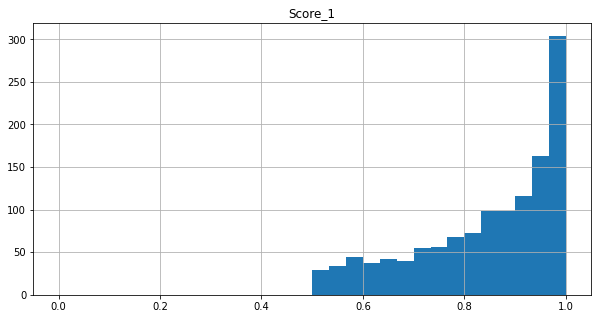

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

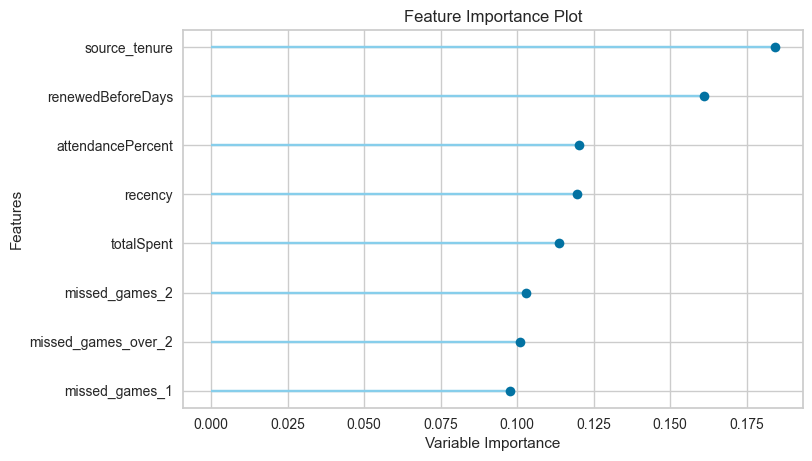

In [14]:
plot_model(best_model, plot='feature')

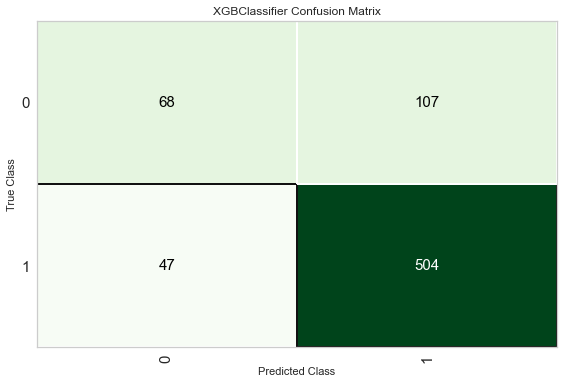

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?